# Initialize Dependencies


In [5]:
! pip install kaggle pandas matplotlib scikit-learn plotly tensorflow scipy

In [18]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [21]:
! cp kaggle.json ~/.kaggle/

In [22]:
! chmod 600 ~/.kaggle/kaggle.json

In [23]:
import os

try:

  import kaggle
except:
  from google.colab import userdata
  os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
  os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd

# Definining Helper Functions

## plot_hist

In [24]:

def plot_hist(data, bins=30):
  # Plot the histogram
  plt.figure(figsize=(8, 6))
  plt.hist(data, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

  # Add titles and labels
  plt.title('Distribution', fontsize=16)
  plt.xlabel('Unit', fontsize=14)
  plt.ylabel('Frequency', fontsize=14)

  # Show grid for better readability
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  # Display the plot
  plt.tight_layout()
  plt.show()



## plot_data_interactive

In [25]:

def plot_data_interactive(x, y):
    # Create an interactive time series plot
    fig = go.Figure()

    # Add a line trace for Consumption
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='lines+markers',
        line=dict(color='blue'),
        marker=dict(size=5),
        name='Unit'
    ))

    # Add titles and labels
    fig.update_layout(
        title='Interactive Time Series',
        xaxis_title='Datetime',
        yaxis_title='Unit',
        template='plotly_white',
        xaxis=dict(rangeslider=dict(visible=True)),  # Enable zoom slider
        yaxis=dict(fixedrange=False)  # Allow zoom on the y-axis
    )

    # Show the plot
    fig.show()


## interpolate

In [26]:
## function for interpolation
## default to linear interpolation

def interpolate(data, resolution, interploation = "linear"):
  return data.resample(resolution).mean().interpolate(interploation)


## combineDateTimeColumns

In [27]:
def combineDateTimeColumns(df, dateColumn, timeColumn):
  # Combine the 'TxnDate' and 'TxnTime' columns into a single datetime column
  df['datetime'] = pd.to_datetime(df[dateColumn] + ' ' + df[timeColumn])

  # Drop unnecessary columns
  df = df.drop([timeColumn, dateColumn], axis=1)

  # Sort by datetime and set it as the index
  df = df.sort_values(by="datetime").set_index("datetime")

  return df

## create_sequences

In [28]:
# Prepare sequences for LSTM

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)


## split_sequences

In [71]:
def split_sequences(X, y, test_size=0.2):
  """
  Splits the sequences into training and validation sets.

  Args:
    X: The input sequences.
    y: The target values.
    test_size: The proportion of the data to use for the test set.

  Returns:
    X_train, X_test, y_train, y_test: The training and test sets for features and targets.
  """

  train_size = int(len(X) * (1 - test_size))
  X_train, X_test = X[:train_size], X[train_size:]
  y_train, y_test = y[:train_size], y[train_size:]

  return X_train, X_test, y_train, y_test

## create_base_model

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def create_base_model(sequence_length):
  """
  This function creates the base LSTM model architecture.

  Args:
      sequence_length: The number of past timesteps to consider.

  Returns:
      A compiled Keras sequential model.
  """
  model = Sequential([
      LSTM(32, activation='tanh', input_shape=(sequence_length, 1)),
      Dropout(0.5),
      Dense(1)  # Predict a single value
  ])
  model.compile(optimizer='adam', loss='mse')
  return model

## train_model

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, X_train, y_train, X_test, y_test, epochs=64, batch_size=32):
  """
  This function trains the model on the provided data.

  Args:
      model: The Keras model to train.
      X_train: Training data for features.
      y_train: Training data for target variable.
      X_test: Testing data for features.
      y_test: Testing data for target variable.
      epochs: Number of training epochs (default: 64).
      batch_size: Batch size for training (default: 32).

  Returns:
      The training history object.
  """
  early_stopping = EarlyStopping(monitor='val_loss', patience=5)
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])
  return history

## test_model

In [74]:
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, X_test, y_test, scaler):
  """
  This function tests the model on the test data and plots the results.

  Args:
      model: The trained Keras model.
      X_test: Testing data for features.
      y_test: Testing data for target variable.
      scaler: The scaler used for normalization.
  """
  # Make predictions
  y_pred = model.predict(X_test)

  # Reverse scaling to get original values
  y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
  y_pred_original = scaler.inverse_transform(y_pred)

  # Convert to actual values (if necessary)
  y_test_original = np.exp(y_test_original)
  y_pred_original = np.exp(y_pred_original)

  # Visualize Predictions
  plt.figure(figsize=(10, 6))
  plt.plot(range(len(y_test_original)), y_test_original, label="True Values")
  plt.plot(range(len(y_pred_original)), y_pred_original, label="Predicted Values", linestyle='--')
  plt.title("LSTM Prediction on Consumption Data")
  plt.xlabel("Time Steps")
  plt.ylabel("Consumption")
  plt.legend()
  plt.show()

# House Hold Energy Data - Time Series

## Data Loading and Exploration

In [29]:
# Define the path
path = "../datasets/vitthalmadane/energy-consumption-time-series-dataset"

# Check if the directory exists
if not os.path.exists(path):
    # Create the directory
    os.makedirs(path)
    print(f"Directory created at: {path}")
else:
    print(f"Directory already exists at: {path}")

## Make sure that kaggle.json is in C:\Users\<username>\.kaggle
kaggle.api.authenticate()

path = "../datasets/vitthalmadane/energy-consumption-time-series-dataset"

kaggle.api.dataset_download_files('vitthalmadane/energy-consumption-time-series-dataset', path=path, unzip=True)

Directory already exists at: ../datasets/vitthalmadane/energy-consumption-time-series-dataset
Dataset URL: https://www.kaggle.com/datasets/vitthalmadane/energy-consumption-time-series-dataset


In [30]:
# Set the directory containing the files
files = os.listdir(path)

# Initialize an empty list to store dataframes
dataframes = []

# Loop through the files in the directory
for file in files:
    # Create the full file path
    file_path = os.path.join(path, file)

    # Read the CSV file
    data = pd.read_csv(file_path)

    # Combine the 'TxnDate' and 'TxnTime' columns into a single datetime column
    data['datetime'] = pd.to_datetime(data['TxnDate'] + ' ' + data['TxnTime'])

    # Drop unnecessary columns
    data = data.drop(["Unnamed: 0", "TxnTime", "TxnDate"], axis=1)

    # Sort by datetime and set it as the index
    data = data.sort_values(by="datetime").set_index("datetime")

    # Append the processed dataframe to the list
    dataframes.append(data)

# Concatenate all the dataframes into a single dataframe
data = pd.concat(dataframes)

# Optionally, reset the index if needed
# merged_data = merged_data.reset_index()

# Display the first few rows of the merged data
print(data.head())


                     Consumption
datetime                        
2022-01-01 00:22:28        1.030
2022-01-01 00:42:33        0.904
2022-01-01 01:01:51        0.904
2022-01-01 01:41:48        1.850
2022-01-01 02:22:52        1.878


In [31]:
## check for null values

pd.isnull(data).sum()

,0
Consumption,0


In [32]:
data["Consumption"].min()

0.0

In [33]:
data["Consumption"].max()

27.284

In [34]:
data.describe()

,Consumption
count,3606.000000
mean,2.781508
std,2.961248
min,0.000000
25%,0.948000
50%,1.032000
75%,4.005500
max,27.284000


<strong>No null values</strong>

In [35]:
## Add 1 to all data

# data['Consumption'] = data['Consumption'] + 1  # Ensure all values are >= 1
# Handle zero and negative values
data[data <= 0] = 1e-6

# Apply log transformation
log_data = np.log(data)

print("Transformed Data:")
print(log_data)

data['log_Consumption'] = np.log(data['Consumption'])

Transformed Data:
                     Consumption
datetime                        
2022-01-01 00:22:28     0.029559
2022-01-01 00:42:33    -0.100926
2022-01-01 01:01:51    -0.100926
2022-01-01 01:41:48     0.615186
2022-01-01 02:22:52     0.630207
...                          ...
2022-02-28 22:25:43     0.141500
2022-02-28 22:44:37    -0.118784
2022-02-28 23:07:15     0.062035
2022-02-28 23:29:13     0.035367
2022-02-28 23:50:27     0.000000

[3606 rows x 1 columns]


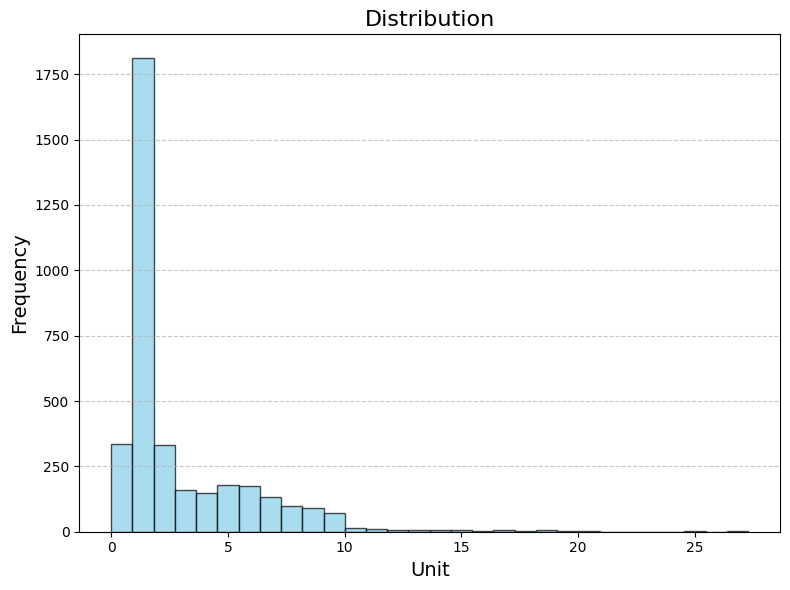

In [36]:
plot_hist(data['Consumption'])

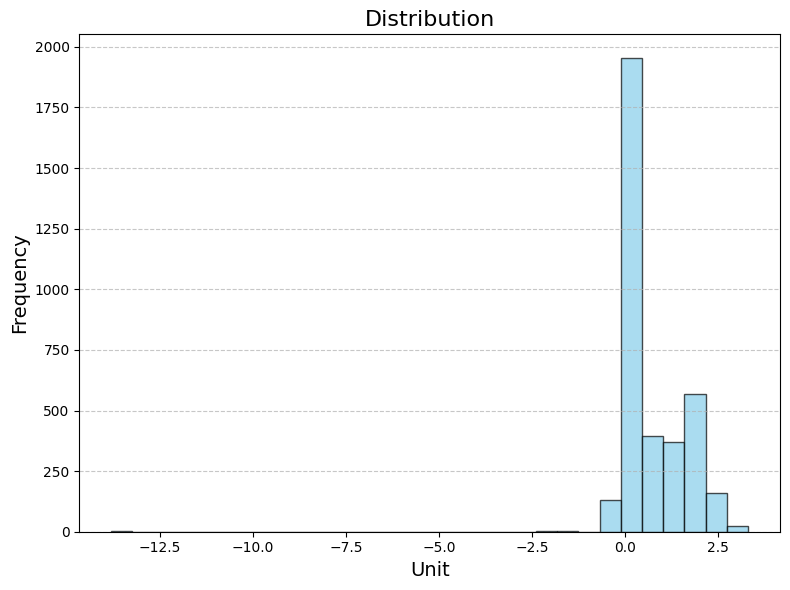

In [37]:

# Apply log transformation to the 'Consumption' column
data['log_Consumption'] = np.log(data['Consumption'])

# Plot or check the distribution before and after
plot_hist(data['log_Consumption'])

<strong>right skew data</strong>

In [38]:
## plot pre-interpolated data

plot_data_interactive(data.index, data['log_Consumption'])

In [39]:


## sample interpolation for getting mean of every 15 minutes
int_data = interpolate(data, "1h")

int_data.head()

,Consumption,log_Consumption
datetime,,
2022-01-01 00:00:00,0.967000,-0.035684
2022-01-01 01:00:00,1.377000,0.257130
2022-01-01 02:00:00,1.485000,0.359109
2022-01-01 03:00:00,0.929333,-0.073351
2022-01-01 04:00:00,0.922667,-0.080723


In [40]:
## plot interpolated data

plot_data_interactive(data.index, data['log_Consumption'])

<strong>To reverse log transformaton</strong> which is important for interpreting machine learning predicitons


<i>np.exp(data['log_Consumption'])</i>

## Model Creation

In [ ]:
sequence_length = 1*4*24; ## 1 day

X, y = create_sequences(
    data,
    sequence_length
    )

X_train, X_test, y_train, y_test = split_sequences(X, y)

print(X_train[:5])

In [77]:
model = create_base_model(sequence_length)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



# Shell AI Hackathon: Solar Irradiance Prediction
https://www.kaggle.com/datasets/dilipkola/shell-ai-solar-irradiance-prediction-hackathon?select=train.csv

## Google Colab Mounting

In [42]:
!kaggle datasets download -d dilipkola/shell-ai-solar-irradiance-prediction-hackathon

! unzip "shell-ai-solar-irradiance-prediction-hackathon.zip"

Dataset URL: https://www.kaggle.com/datasets/dilipkola/shell-ai-solar-irradiance-prediction-hackathon
License(s): other
 97% 281M/290M [00:04<00:00, 85.7MB/s]
100% 290M/290M [00:04<00:00, 65.5MB/s]
Archive:  shell-ai-solar-irradiance-prediction-hackathon.zip
  inflating: 40x40_Projection.npy    
  inflating: 40x40_Raw.npy           
  inflating: solar-hackathon-problem-statement.pdf  
  inflating: test.csv                
  inflating: train.csv               


## Data Loading and Exploration

In [43]:

path = "train.csv"

df = pd.read_csv(path)

print(df.head())

  DATE (YYYY/MM/DD)    MST  Global CMP22 (vent/cor) [W/m^2]  \
0        2020/01/01  00:00                        -0.962276   
1        2020/01/01  00:01                        -0.937921   
2        2020/01/01  00:02                        -0.944395   
3        2020/01/01  00:03                        -0.951350   
4        2020/01/01  00:04                        -0.934976   

   Direct sNIP [W/m^2]  Azimuth Angle [degrees]  Tower Dry Bulb Temp [deg C]  \
0             0.000000                356.85640                        7.216   
1             0.000000                357.65505                        7.251   
2             0.000000                358.45438                        7.256   
3            -0.029673                359.25416                        7.254   
4            -0.054401                  0.05415                        7.331   

   Tower Wet Bulb Temp [deg C]  Tower Dew Point Temp [deg C]  Tower RH [%]  \
0                        0.988                        -7.312  

In [44]:
print(df.columns)

Index(['DATE (YYYY/MM/DD)', 'MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)'],
      dtype='object')


In [45]:
df = combineDateTimeColumns(df, 'DATE (YYYY/MM/DD)', "MST")

In [46]:
df.head()

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
datetime,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
2020-01-01 00:01:00,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2020-01-01 00:02:00,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
2020-01-01 00:03:00,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0
2020-01-01 00:04:00,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,-1,7.20,285.5,806.762,0.0,0.182,0.0,0.0


In [47]:
## check for null values

pd.isnull(df).sum()

,0
Global CMP22 (vent/cor) [W/m^2],0
Direct sNIP [W/m^2],0
Azimuth Angle [degrees],0
Tower Dry Bulb Temp [deg C],0
Tower Wet Bulb Temp [deg C],0
Tower Dew Point Temp [deg C],0
Tower RH [%],0
Total Cloud Cover [%],0
Peak Wind Speed @ 6ft [m/s],0
Avg Wind Direction @ 6ft [deg from N],0


In [48]:
df.describe()

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
count,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000
mean,196.971081,237.119295,180.000016,11.829286,4.610521,-3.115536,40.664133,-0.592061,2.855863,168.420883,816.876516,0.370496,-3.301760,0.064295,0.131975
std,290.616298,367.803389,100.772041,10.703063,6.965858,7.339865,24.196340,432.780701,2.081439,116.719968,5.114894,1.871185,199.263767,0.242353,0.186085
min,-4.764200,-12.403300,0.000120,-16.690000,-17.351000,-24.830000,4.210000,-7999.000000,0.000000,0.000000,794.918000,0.000000,-7999.000000,0.000000,0.000000
25%,-1.106560,-0.197818,89.724415,3.222000,-0.877000,-8.653000,22.300000,-1.000000,1.450000,43.280000,813.736000,0.000000,0.102000,0.000000,0.000000
50%,4.909625,0.256763,179.991490,11.910000,4.727000,-3.643000,33.790000,-1.000000,2.450000,181.200000,817.305000,0.000000,0.643000,0.000000,0.000000
75%,335.747500,518.209250,270.267272,20.350000,10.788000,2.208000,53.530000,35.000000,3.700000,282.200000,820.278250,0.000000,1.043000,0.000000,0.203600
max,1428.650000,1069.200000,359.998560,36.320000,19.416000,17.418000,100.100000,100.000000,24.200000,360.000000,847.963000,28.190000,28.430000,1.000000,2.000000


In [49]:
extractedSolarIrradiance = df["Global CMP22 (vent/cor) [W/m^2]"]

extractedSolarIrradiance.head()

,Global CMP22 (vent/cor) [W/m^2]
datetime,
2020-01-01 00:00:00,-0.962276
2020-01-01 00:01:00,-0.937921
2020-01-01 00:02:00,-0.944395
2020-01-01 00:03:00,-0.951350
2020-01-01 00:04:00,-0.934976


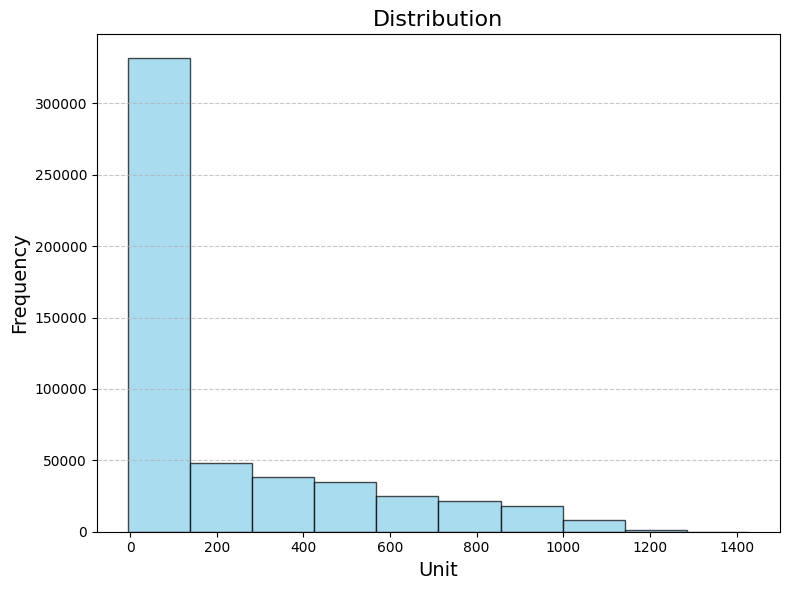

In [50]:
plot_hist(extractedSolarIrradiance,10)

In [51]:
interpolatedData = interpolate(extractedSolarIrradiance, "5min")
print(interpolatedData.head())

datetime
2020-01-01 00:00:00   -0.946184
2020-01-01 00:05:00   -0.907681
2020-01-01 00:10:00   -0.931460
2020-01-01 00:15:00   -0.939490
2020-01-01 00:20:00   -0.952583
Freq: 5min, Name: Global CMP22 (vent/cor) [W/m^2], dtype: float64


right skew

Transformed Data:
                     global irradiance
datetime                              
2020-01-01 00:00:00          -1.361782
2020-01-01 00:05:00          -1.290340
2020-01-01 00:10:00          -1.334303
2020-01-01 00:15:00          -1.349266
2020-01-01 00:20:00          -1.373788


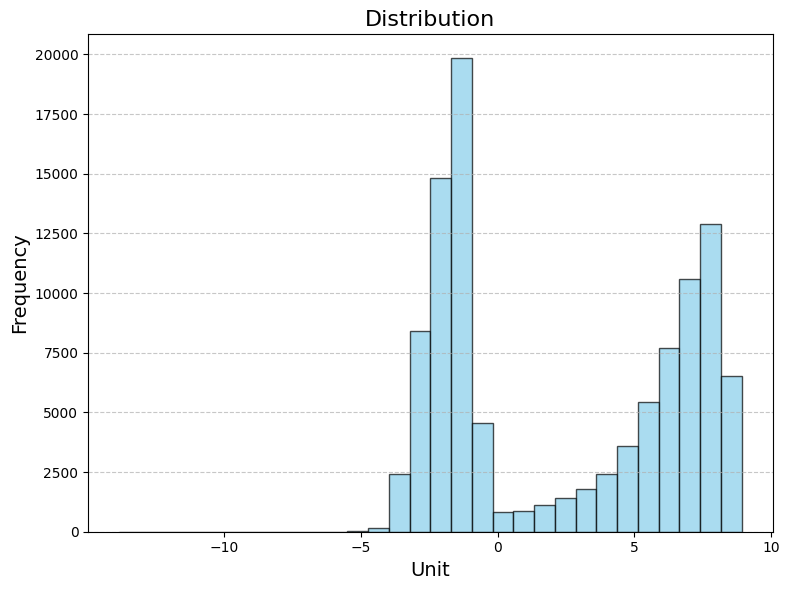

In [52]:
from scipy.stats import yeojohnson
## Add 1 to all data

# data['Consumption'] = data['Consumption'] + 1  # Ensure all values are >= 1
# Handle zero and negative values
# data[data <= 0] = 1e-6

# Apply log transformation
transformData, lmbda = yeojohnson(interpolatedData)
normalizeDf = pd.DataFrame(transformData, index = interpolatedData.index, columns = ["global irradiance"])

print("Transformed Data:")
print(normalizeDf.head())
plot_hist(normalizeDf)
# data['log_Consumption'] = np.log(extractedSolarIrradiance)

became bimodal, possibly because outliers were accentuated by the normalization technique. try another approach

Transformed Data:
                     global irradiance
datetime                              
2020-01-01 00:00:00          -0.448669
2020-01-01 00:05:00          -0.399741
2020-01-01 00:10:00          -0.431177
2020-01-01 00:15:00          -0.441709
2020-01-01 00:20:00          -0.455017


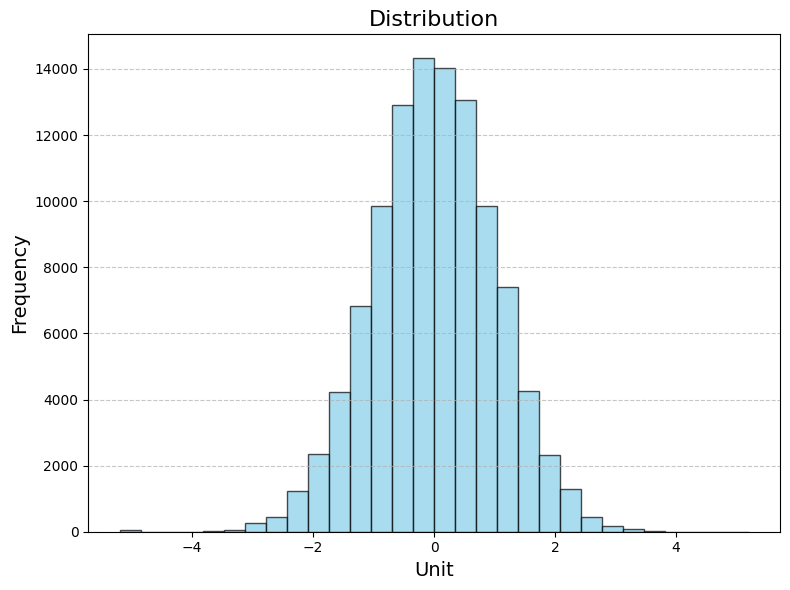

In [53]:
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(output_distribution='normal')
transformData = transformer.fit_transform(interpolatedData.values.reshape(-1,1))

normalizeDf = pd.DataFrame(transformData, index = interpolatedData.index, columns = ["global irradiance"])
print("Transformed Data:")
print(normalizeDf.head())

plot_hist(normalizeDf)

transformed right skewed distribution of solar irradiance to normal distribution using quantile tranformer with "normal" parameter

In [54]:
normalizeDf.describe()

,global irradiance
count,105408.000000
mean,0.003677
std,0.999440
min,-5.199338
25%,-0.661049
50%,0.002702
75%,0.677505
max,5.199338


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning:

X has feature names, but QuantileTransformer was fitted without feature names



Inverse Transformed Data:
                     global irradiance
datetime                              
2020-01-01 00:00:00          -0.946184
2020-01-01 00:05:00          -0.907681
2020-01-01 00:10:00          -0.931460
2020-01-01 00:15:00          -0.939490
2020-01-01 00:20:00          -0.952583


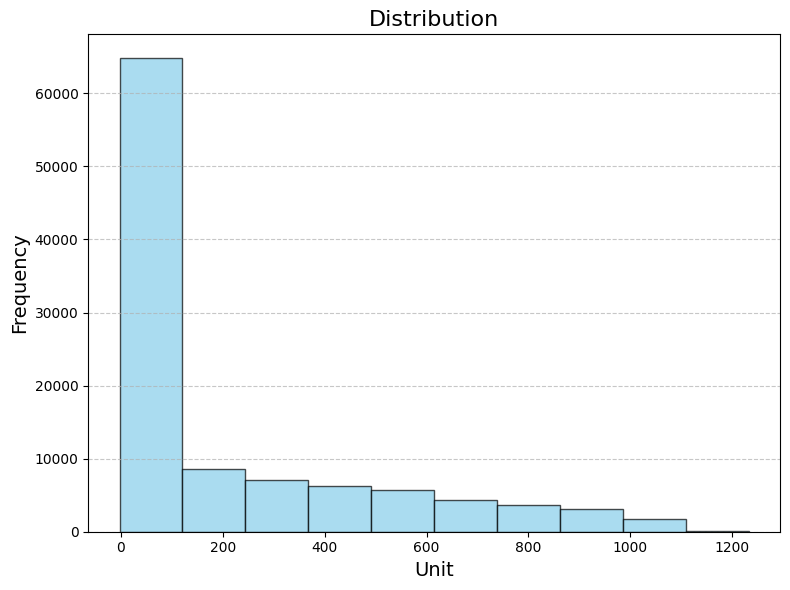

In [55]:
## inverse transform
inverse_transformData = transformer.inverse_transform(normalizeDf)
inverse_normalizeDf = pd.DataFrame(inverse_transformData, index = interpolatedData.index, columns = ["global irradiance"])
print("Inverse Transformed Data:")
print(inverse_normalizeDf.head())
plot_hist(inverse_normalizeDf, 10)

sample inverse transform

In [56]:
inverse_normalizeDf.describe()

,global irradiance
count,105408.000000
mean,196.970131
std,288.607529
min,-2.246460
25%,-1.106178
50%,5.019874
75%,341.244450
max,1231.906000


# Weather Data (Wind speed)
https://www.kaggle.com/datasets/prasad22/weather-data


## Google Colab Mounting

In [57]:
!kaggle datasets download -d prasad22/weather-data

! unzip "weather-data.zip" -d "unzipped_weather_data"

Dataset URL: https://www.kaggle.com/datasets/prasad22/weather-data
License(s): CC0-1.0
 75% 32.0M/42.6M [00:00<00:00, 165MB/s] 
100% 42.6M/42.6M [00:00<00:00, 164MB/s]
Archive:  weather-data.zip
  inflating: unzipped_weather_data/weather_data.csv  


## Data loading and exploration

In [58]:

path = "/content/unzipped_weather_data/weather_data.csv"

df = pd.read_csv(path)

print(df.head())

       Location            Date_Time  Temperature_C  Humidity_pct  \
0     San Diego  2024-01-14 21:12:46      10.683001     41.195754   
1     San Diego  2024-05-17 15:22:10       8.734140     58.319107   
2     San Diego  2024-05-11 09:30:59      11.632436     38.820175   
3  Philadelphia  2024-02-26 17:32:39      -8.628976     54.074474   
4   San Antonio  2024-04-29 13:23:51      39.808213     72.899908   

   Precipitation_mm  Wind_Speed_kmh  
0          4.020119        8.233540  
1          9.111623       27.715161  
2          4.607511       28.732951  
3          3.183720       26.367303  
4          9.598282       29.898622  


In [59]:
print(df.describe())

        Temperature_C    Humidity_pct  Precipitation_mm  Wind_Speed_kmh
count  1000000.000000  1000000.000000    1000000.000000  1000000.000000
mean        14.779705       60.021830          5.109639       14.997598
std         14.482558       17.324022          2.947997        8.663556
min        -19.969311       30.000009          0.000009        0.000051
25%          2.269631       45.008500          2.580694        7.490101
50%         14.778002       60.018708          5.109917       14.993777
75%         27.270489       75.043818          7.613750       22.514110
max         39.999801       89.999977         14.971583       29.999973


In [60]:
df["Date_Time"] = pd.to_datetime(df["Date_Time"])
df = df.set_index("Date_Time").sort_index()
df.head()

,Location,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
Date_Time,,,,,
2024-01-01 00:00:06,Phoenix,0.618582,46.871717,7.379615,5.321995
2024-01-01 00:00:06,Houston,39.469465,34.789904,9.807685,20.475434
2024-01-01 00:00:15,Los Angeles,35.920611,80.786237,0.859060,21.634439
2024-01-01 00:00:18,San Antonio,32.048197,45.576250,2.894071,23.335641
2024-01-01 00:00:31,San Diego,-8.090262,81.472454,5.435076,7.609853


In [61]:
## check for null values

pd.isnull(df).sum()

,0
Location,0
Temperature_C,0
Humidity_pct,0
Precipitation_mm,0
Wind_Speed_kmh,0


In [62]:
df["Location"].unique()

array(['Phoenix', 'Houston', 'Los Angeles', 'San Antonio', 'San Diego',
       'Dallas', 'Philadelphia', 'San Jose', 'Chicago', 'New York'],
      dtype=object)

In [63]:
stateDf = df[df["Location"] == "Phoenix"]
stateDf.head()

,Location,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
Date_Time,,,,,
2024-01-01 00:00:06,Phoenix,0.618582,46.871717,7.379615,5.321995
2024-01-01 00:01:14,Phoenix,8.417553,88.058268,4.151653,10.781841
2024-01-01 00:01:49,Phoenix,5.948831,88.867906,10.076666,27.413116
2024-01-01 00:06:41,Phoenix,22.987189,71.256700,13.640880,25.208850
2024-01-01 00:11:31,Phoenix,12.765205,44.484373,4.144516,19.648863


In [64]:
stateDf = stateDf["Wind_Speed_kmh"]

stateDf.head()


,Wind_Speed_kmh
Date_Time,
2024-01-01 00:00:06,5.321995
2024-01-01 00:01:14,10.781841
2024-01-01 00:01:49,27.413116
2024-01-01 00:06:41,25.208850
2024-01-01 00:11:31,19.648863


In [65]:
interpolateStateDf = interpolate(stateDf, "5min")
interpolateStateDf.head()

,Wind_Speed_kmh
Date_Time,
2024-01-01 00:00:00,14.505651
2024-01-01 00:05:00,25.208850
2024-01-01 00:10:00,19.648863
2024-01-01 00:15:00,21.717175
2024-01-01 00:20:00,16.960979


In [70]:
plot_data_interactive(interpolateStateDf.index, interpolateStateDf.values)

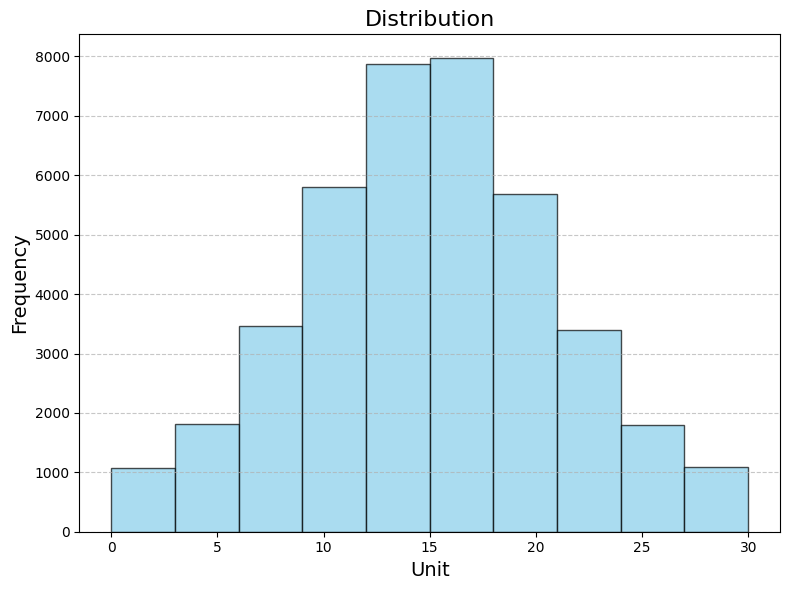

In [66]:
plot_hist(interpolateStateDf,10)

the data is normally distributed

In [67]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
scaled_data = scaler.fit_transform(interpolateStateDf.values.reshape(-1,1))

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=["wind speed"], index=interpolateStateDf.index)

print(scaled_df.head())

                     wind speed
Date_Time                      
2024-01-01 00:00:00    0.483536
2024-01-01 00:05:00    0.840362
2024-01-01 00:10:00    0.655001
2024-01-01 00:15:00    0.723955
2024-01-01 00:20:00    0.565392


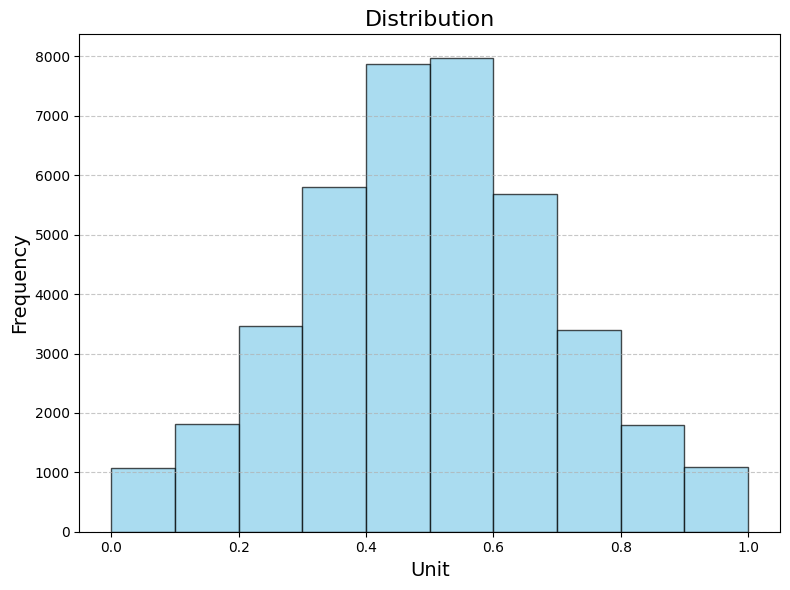

In [68]:
plot_hist(scaled_df,10)

scaled data using min-max for smaller computional requirements when fed to machine learning models

                     wind speed
Date_Time                      
2024-01-01 00:00:00   14.505651
2024-01-01 00:05:00   25.208850
2024-01-01 00:10:00   19.648863
2024-01-01 00:15:00   21.717175
2024-01-01 00:20:00   16.960979


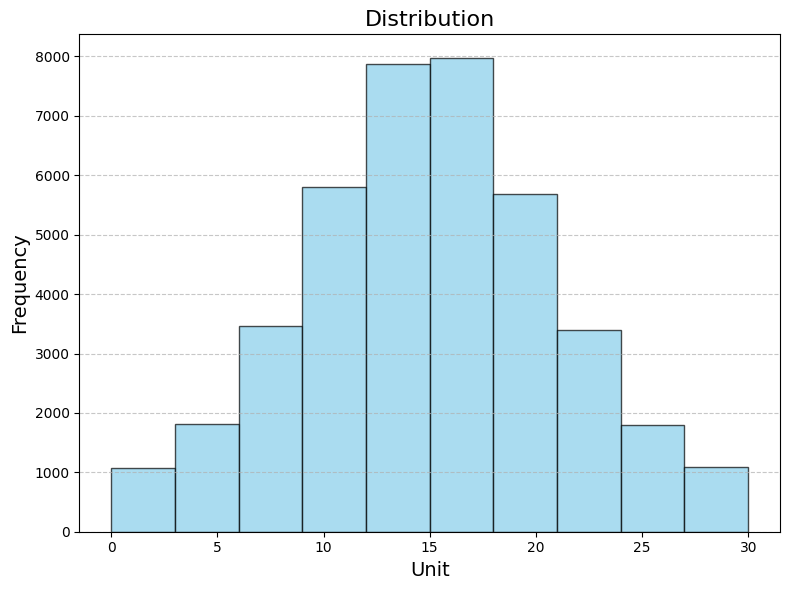

In [69]:
# Inverse transform the scaled data
original_data = scaler.inverse_transform(scaled_df)

# Create a new DataFrame with the original data
original_df = pd.DataFrame(original_data, columns=["wind speed"], index=interpolateStateDf.index)

print(original_df.head())
plot_hist(original_df,10)

sample inverse scaling